In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import numpy as np
import time
import seaborn as sns

from models import *
from utils import *
from train import *
from bvc import *

sns.set(font_scale=1.2)
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class RectangleEnvironment:
    '''
    Rectangular environment to obtain BVC and PC firing rates
    '''
    def __init__(self, l, w):
        self.l = torch.Tensor([l]) # maximum length
        self.w = torch.Tensor([w]) # maximum width
        self.aspect_ratio = l / w
        
    def compute_wall_dist(self, loc):
        '''
        Calculates the distances, bearings and subtended angles of a rat location
        returns distances, bearings, angles. Each list of length 4
        left/up - positive dist, right/down - negative dist
        '''
        x, y = loc
        x = torch.Tensor([x]) if not isinstance(x, torch.Tensor) else x
        y = torch.Tensor([y]) if not isinstance(y, torch.Tensor) else y
        assert torch.any(x) > 0 and torch.any(x) < self.l
        assert torch.any(y) > 0 and torch.any(y) < self.w
        
        distances, bearings, angles = [], [], []
        
        # up wall
        distances.append(y)
        bearings.append(0 * torch.pi)
        angles.append(torch.arctan(x/y) + torch.arctan((self.l-x)/y))

        # right wall
        distances.append(self.l - x)
        bearings.append(1/2 * torch.pi)
        angles.append(torch.arctan(y/(self.l-x)) + torch.arctan((self.w-y)/(self.l-x)))
        
        # down wall
        distances.append(self.w - y)
        bearings.append(1 * torch.pi)
        angles.append(torch.arctan(x/(self.w-y)) + torch.arctan((self.l-x)/(self.w-y)))

        # left wall
        distances.append(x)
        bearings.append(3/2* torch.pi)
        angles.append(torch.arctan(y/x) + torch.arctan((self.w-y)/x))
        
        return distances, bearings, angles

    def visualise_bvc_firing_rates(self, bvcs, n=100):
        '''
        Visualises firing rate of BVC(s)
        '''
        if not isinstance(bvcs, list):
            bvcs = [bvcs]
        n_bvcs = len(bvcs)
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, n),
            torch.linspace(1e-3, self.w.item()-1e-3, n))
        distances, bearings, angles = self.compute_wall_dist((x,y))
        
        plt.figure(figsize=(6*n_bvcs, 6/self.aspect_ratio))
        firing_rates = [cell.compute_BVC_firing(distances, bearings, angles) for cell in bvcs]
        
        for i, bvc in enumerate(bvcs):
            plt.subplot(1, n_bvcs, i+1)
            plt.scatter(x, self.w-y, c= firing_rates[i])
            plt.title(f'd = {int(bvc.d)}, deg = {int(bvc.phi/torch.pi*180)}')
        plt.show()
        
    def visualise_pc_firing_rates(self, pcs, n=100):
        '''
        Visualises firing rate of PC(s)
        '''
        if not isinstance(pcs, list):
            pcs = [pcs]
        n_pcs = len(pcs)
        
        x, y = torch.meshgrid(
            torch.linspace(1e-3, self.l.item()-1e-3, n),
            torch.linspace(1e-3, self.w.item()-1e-3, n))
        distances, bearings, angles = self.compute_wall_dist((x,y))
        
        plt.figure(figsize=(6*n_pcs, 6/self.aspect_ratio))
        firing_rates = [cell.compute_PC_firing(distances, bearings, angles) for cell in pcs]
        
        for i, pc in enumerate(pcs):
            plt.subplot(1, n_pcs, i+1)
            plt.scatter(x, self.w-y, c=firing_rates[i])
            plt.title(f'Place cell {i+1}/{n_pcs}')
        plt.show()

In [3]:
class BoundaryVectorCell:
    '''
    A boundary vector cell initiliased with preferred distance (mm) and angle (rad)
    '''
    def __init__(self, d, phi, sigma_zero=122, beta=1830, sigma_ang=0.2, multiplier=10000, maxfire=5) -> None:
        self.d = torch.Tensor([d])
        self.phi = torch.Tensor([phi])
        self.sigma_zero = sigma_zero                                                 # Hartley 2000: sigZero = 122 mm
        self.beta = beta                                                             # Hartley 2000: beta = 1830 mm
        self.sigma_ang = torch.Tensor([sigma_ang])                                   # Hartley 2000: angSig = 0.2 rad
        self.sigma_rad = torch.Tensor([((self.d/self.beta)+1) * self.sigma_zero])    # Hartley 2000: sigma_rad = [(d/beta) + 1] * sigma_zero
        self.multiplier = multiplier
        self.maxfire = maxfire

    def compute_BVC_firing_single_boundary(self, r, theta):
        '''
        Computes the firing of BVC given a current distance and angle to a single boundary.
        Firing rate is proportional to product of two gaussians centerred at the preferred distance and angle
        Vectorised: r and theta can be arrays or matrices
        
        :param r:       animal's allocentric distance to boundary
        :param theta:   animal's allocentric bearing to boundary
        '''
        unscaled_firing_rate = torch.exp(-(r - self.d) ** 2 / (2 * self.sigma_rad ** 2))/ \
                torch.sqrt(2 * torch.pi * self.sigma_rad ** 2) * \
                    torch.exp(-(theta - self.phi) ** 2 / (2 * self.sigma_ang ** 2))/ \
                        torch.sqrt(2 * torch.pi * self.sigma_ang ** 2)
        
        return unscaled_firing_rate
    
    def compute_BVC_firing(self, distances, bearings, subtended_angles):
        '''
        A section of wall at distance r, bearing theta, subtending a angle dtheta at the rat contributes
        dfi = gi(r, theta) * dtheta
        The firing rate is found by integrating to find the net contribution of all the environment's boundaries
        '''
        n_boundaries = len(distances)
        
        unscaled_firing_rates = torch.stack([self.compute_BVC_firing_single_boundary(distances[i], bearings[i]) for i in range(n_boundaries)], dim=0)
        
        subtended_angles = torch.stack(subtended_angles, dim=0)
        firing_rates = self.multiplier * torch.sum(torch.multiply(unscaled_firing_rates, subtended_angles), dim=0)
        
        if self.maxfire is not False:
            return torch.clamp(firing_rates, min=None, max=self.maxfire)
        else:
            return firing_rates

In [4]:
def plot_bvc_firing_field(bvcs, max_d='auto', n=200):
    '''
    Plots firing field of (multiple) BVCs
    '''
    if not isinstance(bvcs, list):
        bvcs = [bvcs]
    n_bvcs = len(bvcs)
    
    if max_d =='auto':
        max_d = int(max([i.d for i in bvcs]) * 1.5)
    rads = torch.linspace(-torch.pi, torch.pi, n)
    ds = torch.linspace(0, max_d, n)

    rads_mat, ds_mat = torch.meshgrid(rads, ds)

    plt.figure(figsize=(4*n_bvcs, 4))
    for i in range(n_bvcs):
        ax = plt.subplot(1, n_bvcs,i+1, projection='polar')
        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N', offset=0)
        firing_rates = bvcs[i].compute_BVC_firing_single_boundary(ds_mat, rads_mat)
        ax.scatter(rads_mat, ds_mat, c=firing_rates, s=1, cmap='hsv', alpha=0.75)
    plt.show()

In [5]:
class PlaceCell:
    '''
    A place cell receives input from multiple boundary vector cells
    The firing F_j(x) of PC j at location x is proportional to the thresholded, weighted sum of the N BVC sets that connect to it
    Output is the thresholded firing sum, each at the same allocentric reference frame, scaled by a coefficient A
    '''
    def __init__(self, bvcs=False, connection_weights=False, non_linearity=nn.ReLU(), A=5000, T=12, max_fire=100):
        
        if bvcs is not False:
            self.bvcs = bvcs
            self.n_bvcs = len(self.bvcs)
            self.connection_weights = connection_weights
            assert len(self.connection_weights) == len(self.bvcs)
            
        self.T = T
        self.non_linearity = nn.ReLU()
        self.A = A
        self.max_fire = max_fire
    
    def create_random_bvcs(self, n_bvcs, max_r=1000):
        self.n_bvcs = n_bvcs
        rs = dist.Uniform(low=0, high=1000).sample(sample_shape=torch.Size([n_bvcs]))
        phis = dist.Uniform(low=0, high=2*torch.pi).sample(sample_shape=torch.Size([n_bvcs]))
        self.bvcs = [BoundaryVectorCell(ds[i], phis[i]) for i in range(n_bvcs)]
        self.connection_weights = torch.ones(n_bvcs)
        
    def compute_PC_firing(self, distances, bearings, subtended_angles):
        try:
            self.bvcs
        except:
            raise AttributeError('No BVCs initialised')
            
        bvc_firing_rates = torch.stack([bvc.compute_BVC_firing(distances, bearings, subtended_angles) for bvc in self.bvcs], dim=-1)
        weighted_sum = torch.sum(torch.mul(bvc_firing_rates, self.connection_weights), dim=-1)
        thresholded_sum = self.A * weighted_sum - self.T
        if self.max_fire is False:
            return self.non_linearity(thresholded_sum)
        else:
            return torch.clamp(self.non_linearity(thresholded_sum), min=None, max=self.max_fire)
    
    def BCM_weight_update(self, PC_firing, BVC_firings, D=0.2, F0=0.3, p=3, Phi=lambda F, xi: nn.Tanh(F*(F-xi))):
        '''
        Sustained firing of post-synatic cell below a dynamic threshold leads to weakening of the connection from the pre-synaptic cell
        and vice versa.
        Magnitude of change between PC and BVC i is dw = D(f_i(x) Phi(Fj(x), xi)), xi = (<Fj>/F0)^p*<Fj>
        '''
        Fj = torch.mean(PC_firing)
        xi = torch.pow((Fj/F0), p) * Fj
        dW = [D * BVC_firings[i] *Phi(PC_firing, xi) for i in range(self.n_bvcs)]
        
        return dW

In [6]:
# simute 7 BVCs to feed into a place cell
l = 1200
w = 1200
env = RectangleEnvironment(l, w)
connection_weights = torch.ones(10)
dists = [81, 169, 265, 349, 482.5, 606.5, 741, 829, 348, 444]
preferred_angle= dist.Uniform(0, torch.pi).sample(sample_shape=torch.Size([10]))
preferred_angle

tensor([0.9303, 1.6228, 0.7906, 2.1632, 0.2324, 2.7223, 0.4291, 0.3219, 0.5782,
        2.2822])

/home/daniel/.local/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


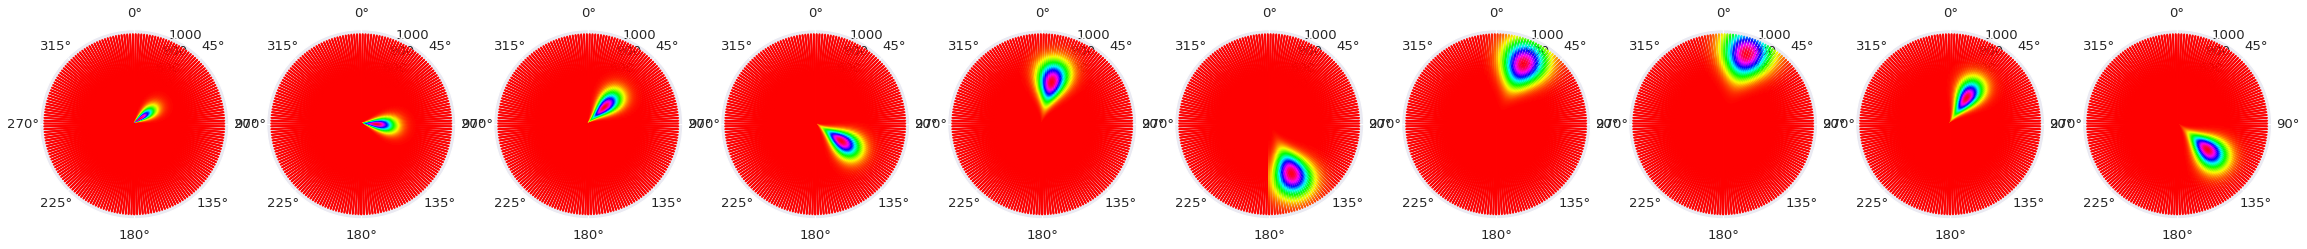

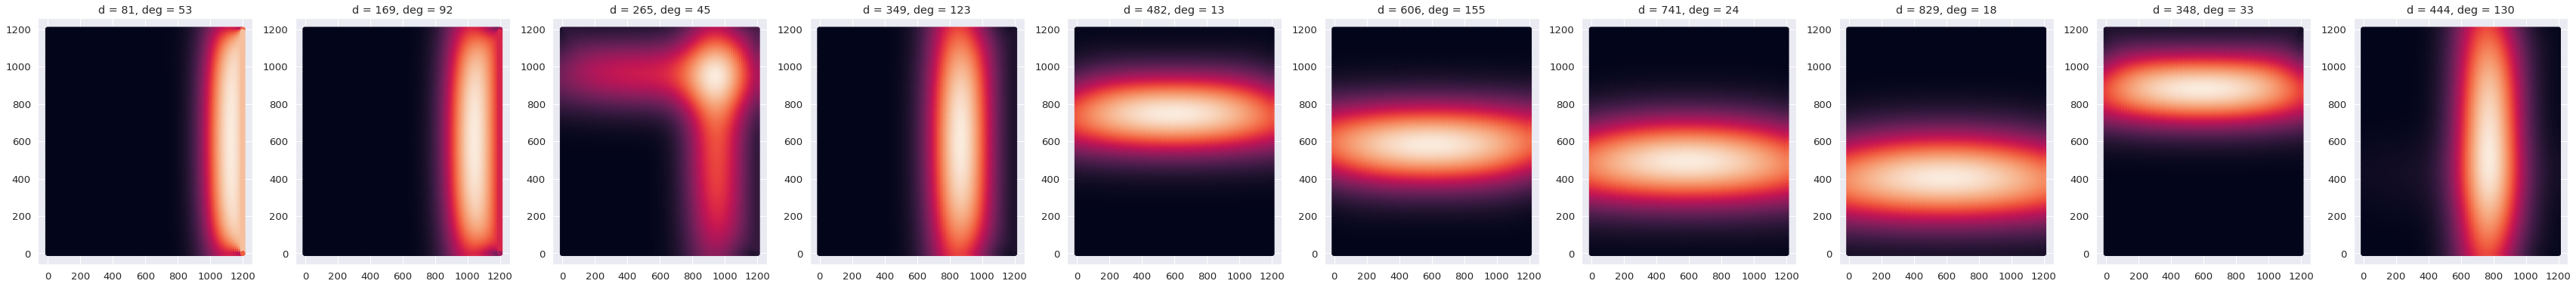

In [7]:
# simulate 10 BVCs
BVCs = [BoundaryVectorCell(dists[i], preferred_angle[i], multiplier=1) for i in range(len(dists))]
plot_bvc_firing_field(BVCs, max_d=1000) 
env.visualise_bvc_firing_rates(BVCs)

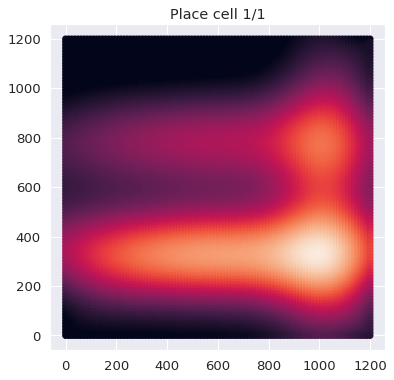

In [33]:
connection_weights = torch.ones(10)
PC = PlaceCell(bvcs=BVCs, connection_weights=connection_weights, max_fire=100)
env.visualise_pc_firing_rates(PC)

In [34]:
import torch.distributions as dist

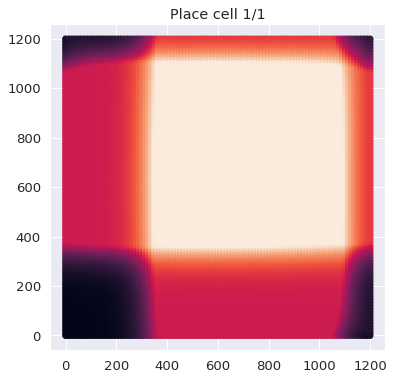

In [61]:
env.visualise_pc_firing_rates(PC)